In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers import Activation, Dense,Flatten, Dropout, Input, Concatenate
from keras.layers import MaxPooling2D, Conv2D, AveragePooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import keras
from keras.losses import categorical_crossentropy
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [16]:
lmbda = 0.1
batch_size = 16 # ネットワークを軽くするか、バッチサイズを減らすしかないらしい
epochs = 3
seed = 0
learning_rate = 0.1
cutout = 16
budget = 0.3

np.random.seed(seed)
tf.set_random_seed(seed)

## model

In [17]:
VGG13 = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

input_shape = (32, 32, 3)
num_classes = 10
name = 1

input_tensor = Input(shape=input_shape, name='inputs')
net = input_tensor

for x in VGG13:
    if x == 'M':
        net = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool'+str(name))(net)
        name += 1
    else:
        net = Conv2D(x, (3, 3), padding='same', name='conv'+str(name))(net)
        net = BatchNormalization(name='norm'+str(name))(net)
        net = Activation('relu', name='acti'+str(name))(net)
        name += 1
        
net = AveragePooling2D(pool_size=(1, 1), strides=(1,1), padding='same', name='avepool')(net)
net = Flatten(name='flatten')(net)
classifier = Dense(num_classes, activation='softmax', name='classifier')(net)
confidence = Dense(1, activation='sigmoid',name='confidence')(net)
prediction = keras.layers.concatenate([classifier, confidence], axis=1, name='prediction')

model = Model(input_tensor, prediction)

## preprocess images

In [18]:
def preprocess(images, length, train=True):
    
    # Normalize
    mean = [x / 255.0 for x in [125.3, 123.0, 113.9]]
    std = [x / 255.0 for x in [63.0, 62.1, 66.7]]
    images = ((images - mean) / std)
    
    # Cutout
    if train:
        if np.random.choice([0, 1]):
            h = images[0].shape[0]
            w = images[0].shape[1]
            mask = np.ones((h, w), dtype='float32')
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = int(np.clip(y - length / 2, 0, h))
            y2 = int(np.clip(y + length / 2, 0, h))
            x1 = int(np.clip(x - length / 2, 0, w))
            x2 = int(np.clip(x + length / 2, 0, w))
            mask[y1: y2, x1: x2] = 0.
            mask = mask[:, :, np.newaxis]
            mask = np.tile(mask, 3)
            images = images * mask
        
    return images

In [19]:
def add_label(labels):
    conf_label = np.ones((labels.shape[0], 1))
    new_labels = np.hstack((labels, conf_label))
    return new_labels

 ## dataset

In [20]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [21]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [22]:
x_train = preprocess(x_train, cutout, True)
x_test = preprocess(x_test, cutout, False)
y_train = add_label(keras.utils.to_categorical(y_train, num_classes=num_classes)) # (50000, 11)
y_test = add_label(keras.utils.to_categorical(y_test, num_classes=num_classes)) # (10000, 11)

## loss

In [23]:
def compute_loss(y_true, y_pred):
    # 変数定義
    global lmbda
    # 順伝播の出力
    prediction = tf.slice(y_pred, [0, 0], [batch_size, num_classes])
    confidence = tf.slice(y_pred, [0, num_classes], [batch_size, 1])
    
    # clipメソッドでインプットを範囲内に収める
    eps = 1e-12
    pred_original = tf.clip_by_value(prediction, 0. + eps, 1. - eps)
    confidence = tf.clip_by_value(confidence, 0. + eps, 1. - eps)
    
    # 予測値の補正を行う（ヒント部分）
    # Randomly set half of the confidences to 1 (i.e. no hints)
    means = tf.constant([.5])
    b = tf.where(tf.random_uniform([tf.shape(confidence)[0], 1], minval=0, maxval=1) - means < 0,  
                 tf.ones([tf.shape(confidence)[0], 1]), 
                 tf.zeros([tf.shape(confidence)[0], 1]))
    
    # confを設定
    conf = tf.add(confidence * b, 1.0 - b)
    conf = tf.tile(conf, [1, 10])
    
    # 予測を小さくして、正解ラベルの分布を足す
    pred_new = tf.add(pred_original * conf, y_true[:, :-1] * (1 - conf))
    pred_new = tf.log(pred_new)
    
    # 損失計算
    xentropy_loss = tf.reduce_mean(-tf.reduce_sum(y_true[:, :-1] * pred_new, reduction_indices=[1]))
    confidence_loss = tf.reduce_mean(-tf.log(confidence))

    # 損失を定義
    total_loss = tf.add(xentropy_loss, (lmbda * confidence_loss))
    
    # lambdaを更新
    lm_val = tf.cond(budget > confidence_loss, lambda: 1.01, lambda: 0.99)
    lmbda = lmbda / lm_val
    
    return total_loss

## Plot histogram

In [24]:
def plot_histograms(corr, conf, bins=50, norm_hist=True):
    plt.figure(figsize=(6, 4))
    sns.distplot(conf[corr], kde=False, bins=bins, norm_hist=norm_hist, label='Correct')
    sns.distplot(conf[np.invert(corr)], kde=False, bins=bins, norm_hist=norm_hist, label='Incorrect')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig( 'logs/foo.png' )

## Custom callbacks
https://stackoverflow.com/questions/47079111/create-keras-callback-to-save-model-predictions-and-targets-for-each-batch-durin

In [25]:
class PlotHistograms(keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset
        self.classify = []
        self.targets = []

    def on_epoch_end(self, epoch, logs={}):
        x_data, y_data = self.dataset
        outputs = self.model.predict(x_data, verbose=1)
        
        self.classify.append(outputs[:, :-1])
        self.targets.append(y_data[:, :-1])
        
        pred_label = np.array([x.argmax() for x in self.classify[epoch]])
        true_label = np.array([x.argmax() for x in self.targets[epoch]])
        corr = pred_label == true_label
        conf = outputs[:, -1]
        
        bins=50
        norm_hist=True
        plt.figure(figsize=(6, 4))
        sns.distplot(conf[corr], kde=False, bins=bins, norm_hist=norm_hist, label='Correct')
        sns.distplot(conf[np.invert(corr)], kde=False, bins=bins, norm_hist=norm_hist, label='Incorrect')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()
        plt.savefig( 'logs/%03d.png' % epoch )

## optimizer, scheduler

In [26]:
optim = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, decay=5e-4, nesterov=True)

def schedule(epoch, decay=0.2):
    if epoch in [60, 120, 160]:
        return learning_rate * decay
    else:
        return learning_rate

cbk = PlotHistograms((x_test, y_test))
callbacks = [keras.callbacks.LearningRateScheduler(schedule), cbk]

In [27]:
model.compile(optimizer=optim, loss=compute_loss)

## Train

Epoch 1/3
10000/10000 [==============================] - 2s 216us/step
Epoch 2/3
10000/10000 [==============================] - 2s 198us/step
Epoch 3/3
10000/10000 [==============================] - 2s 202us/step


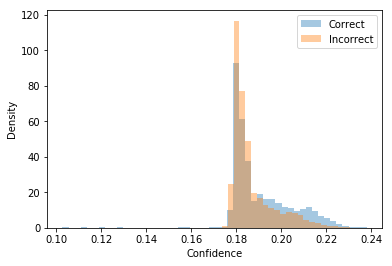

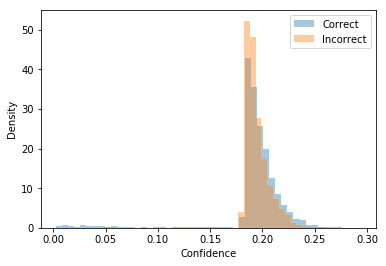

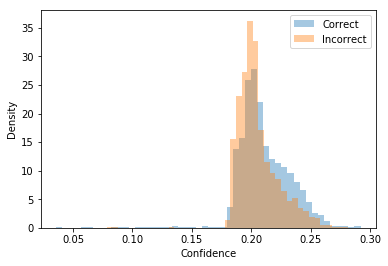

In [28]:
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1, 
                    callbacks=callbacks)
                    #validation_data=(x_test, y_test))

## evaluate

In [18]:
from keras.models import load_model
model.load_weights('logs/confidence_estimation.h5')

In [19]:
from keras.datasets import cifar10
(test_x, test_y), (_, _) = cifar10.load_data()

In [20]:
ind_x = preprocess(test_x.copy(), cutout, True)
ind_y = test_y.copy()
ood_x = preprocess(test_x.copy(), cutout, False)
ood_y = test_y.copy()

In [29]:
ind_image = ind_x[1]
ind_image = ind_image[np.newaxis, :, :, :]
ood_image = ood_x[1]
ood_image = ood_image[np.newaxis, :, :, :]

In [30]:
ind_pred = model.predict(ind_image, batch_size=1, verbose=1)
ood_pred = model.predict(ood_image, batch_size=1, verbose=1)

1/1 [==============================] - 0s 5ms/step


In [31]:
ind_class = ind_pred[0, :-1].argmax()
ind_label = ind_y[0]
ind_conf = ind_pred[0, -1]

ood_class = ood_pred[0, :-1].argmax()
ood_label = ood_y[0]
ood_conf = ood_pred[0, -1]

In [32]:
print(ind_class, ind_label, ind_conf)
print(ood_class, ood_label, ood_conf)

9 [6] 0.9999182
9 [6] 0.99999964


## Display

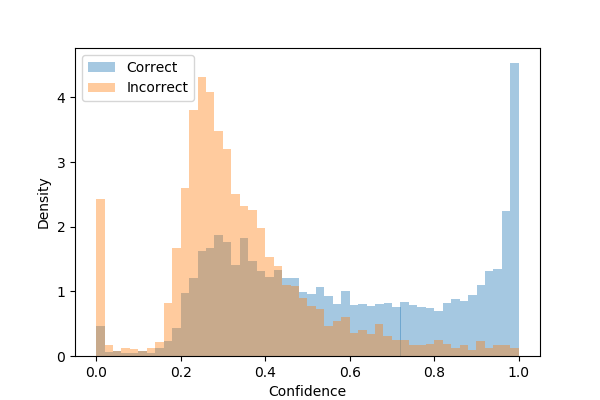

In [20]:
from IPython.display import Image, display_png
display_png(Image('logs/052.png'))